**Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('./data/BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.shape

(3212, 7)

In [4]:
features = ['Close', 'Open', 'Low', 'High', 'Volume']
data = df[features]
data.head()

,Close,Open,Low,High,Volume
0,457.334015,465.864014,452.421997,468.174011,21056800
1,424.440002,456.859985,413.104004,456.859985,34483200
2,394.795990,424.102997,384.532013,427.834991,37919700
3,408.903992,394.673004,389.882996,423.295990,36863600
4,398.821014,408.084991,393.181000,412.425995,26580100


In [5]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data[features])

In [6]:
train_ratio = 0.8
train_size = int(len(data_normalized) * train_ratio)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

In [7]:
def create_sequences(data, seq_length=50, space=5):
    X = []
    y = []
    for i in range(len(data) - (seq_length + space)):
        seq = data[i:i+seq_length]
        target = data[i+seq_length+space][0]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

In [8]:
class BtcDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 8

torch.manual_seed(1)
train_dataset = BtcDataset(X_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = len(features)
hidden_size = 128
output_size = 1

torch.manual_seed(1)
model = LSTM(input_size, hidden_size, output_size)
model

LSTM(
  (lstm): LSTM(5, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

torch.manual_seed(1)

for epoch in range(num_epochs):
    for batch_X, batch_y in train_dataloader:        
        output = model(batch_X)
        output = output.view(-1)
        loss = loss_fn(output, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.000336
Epoch [20/100], Loss: 0.000361
Epoch [30/100], Loss: 0.000030
Epoch [40/100], Loss: 0.000034
Epoch [50/100], Loss: 0.000441
Epoch [60/100], Loss: 0.001065
Epoch [70/100], Loss: 0.000060
Epoch [80/100], Loss: 0.000728
Epoch [90/100], Loss: 0.000057
Epoch [100/100], Loss: 0.000147


In [12]:
model.eval()
with torch.no_grad():
    X_test_eval = torch.from_numpy(X_test).float()
    y_pred = model(X_test_eval)
    test_loss = loss_fn(y_pred, torch.from_numpy(y_test).view(-1, 1))
    print(f'Test Loss: {test_loss.item():.6f}\n')
    
y_pred = np.append(y_pred, np.zeros((588, 4), dtype=int), axis=1)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.expand_dims(y_test, axis=1)
y_test = np.append(y_test, np.zeros((588, 4), dtype=int), axis=1)
y_test = scaler.inverse_transform(y_test)

np.set_printoptions(suppress=True, precision=3)
print("Last 10 predicted prices:")
print(y_pred[-10:, 0])

print("\nLast 10 actual prices:")
print(y_test[-10:, 0])

Test Loss: 0.001208

Last 10 predicted prices:
[26339.397 26736.844 28065.674 29968.792 29957.22  30763.739 30523.204
 30629.506 30260.807 30718.254]

Last 10 actual prices:
[30548.695 30480.262 30271.131 30688.164 30086.246 30445.352 30477.252
 30590.078 30620.77  30668.17 ]


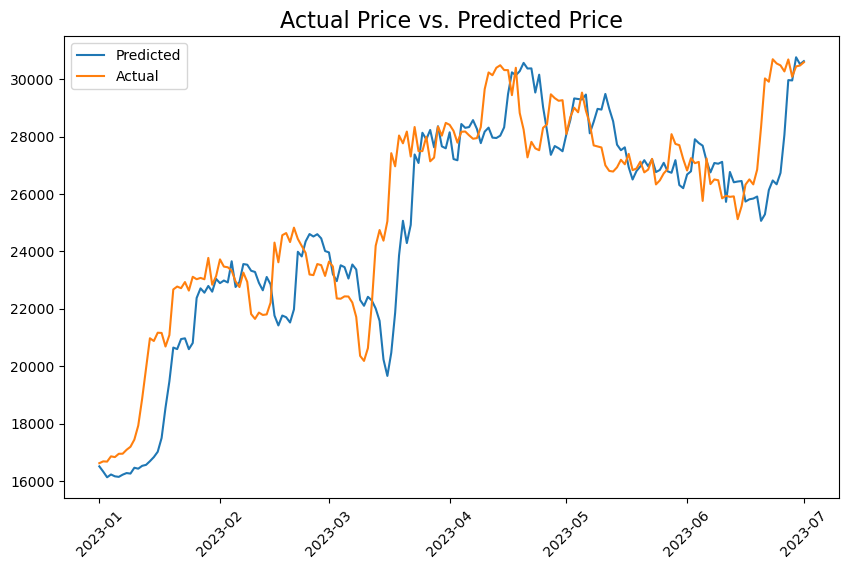

In [13]:
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.ticklabel_format(style='plain')

x = df['Date'][-184:-2]
x_list = list(x)
x_labels = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07']
x_ticks = [x_list[0], x_list[31], x_list[59], x_list[90], x_list[120], x_list[151], x_list[-1]]

ax.plot(x, y_pred[-184:-2, 0], label="Predicted")
ax.plot(x, y_test[-184:-2, 0], label="Actual")

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)

ax.set_title('Actual Price vs. Predicted Price', fontsize=16)

ax.legend()

plt.show()

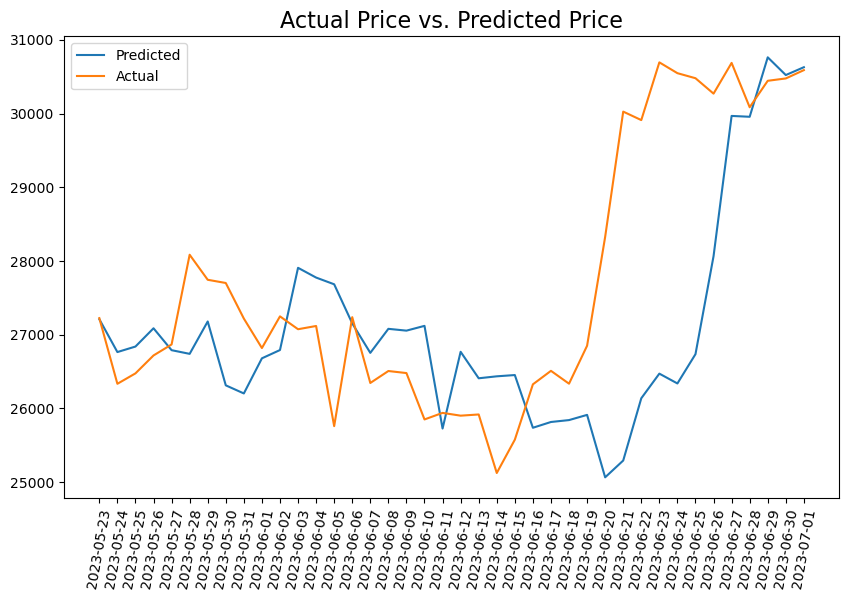

In [14]:
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.ticklabel_format(style='plain')

x = df['Date'][-42:-2]
x_list = list(x)

ax.plot(x, y_pred[-42:-2, 0], label="Predicted")
ax.plot(x, y_test[-42:-2, 0], label="Actual")

ax.set_xticks(list(x))
ax.set_xticklabels(list(x), rotation=80)

ax.set_title('Actual Price vs. Predicted Price', fontsize=16)

ax.legend()

plt.show()